<a href="https://colab.research.google.com/github/doumoh/RIS_aided_communication/blob/main/Neural_Receiver_for_OFDM_SIMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Receiver for OFDM SIMO Systems with differentiable EM-based RIS and RT-based channel models
In this notebook, we train a neural receiver for OFDM SIMO systems in a physically realistic wireless environment. The architecture includes a differentiable electromagnetic (EM)-aware reconfigurable intelligent surface (RIS) and a ray tracing (RT)-based channel model, as illustrated in the figure. The transmitter processes information bits through an outer encoder, QPSK mapper, and OFDM resource grid mapper. The resulting resource grid is then passed through a ray tracing-based channel, which leverages computed fields and traced paths to generate the channel impulse response (CIR). After applying the OFDM channel, the neural receiver directly processes the received resource grid to estimate log-likelihood ratios (LLRs), bypassing traditional channel estimation and equalization. These LLRs are then decoded by the outer decoder to reconstruct the original information bits.

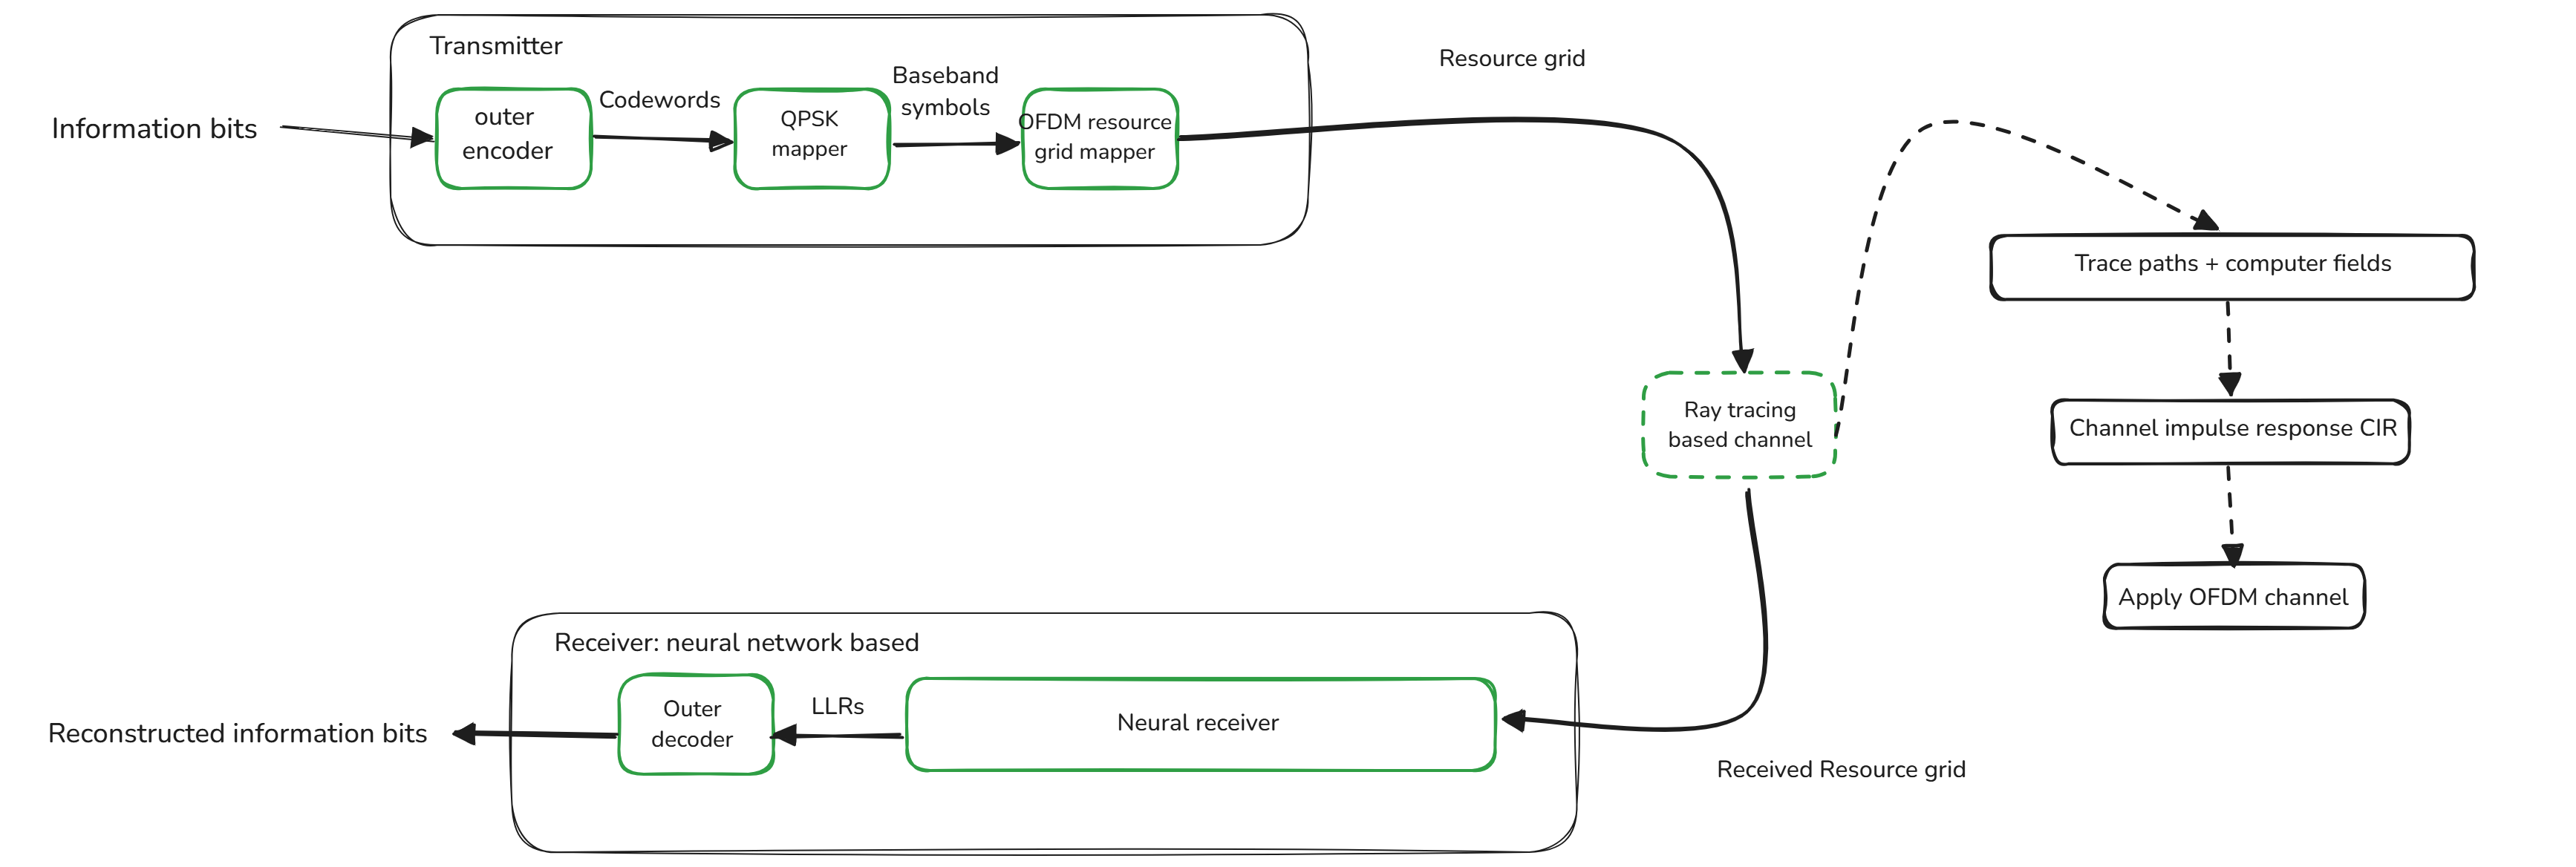

# Install Specific Versions
 Reinstalls specific versions of these packages to ensure compatibility and stability for the project environment.

In [1]:
!pip uninstall -y sionna tensorflow tensorflow-probability numpy
!pip install sionna==0.19 tensorflow tensorflow-probability numpy --upgrade
!pip uninstall -y mitsuba
!pip install mitsuba==3.5.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of ipywidgets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of ipywidgets to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 19.6 MB/s eta 

# GPU Configuration and Imports


In [ ]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna==0.19")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42 # Set seed for reproducible random number generation

# Imports and Setup
This cell imports essential Python libraries (like Matplotlib and NumPy) and TensorFlow Keras components for building neural network models.

Sionna and Related Modules
It also imports various functions and classes from Sionna — a library for simulating wireless communication systems — including channel models, coding, mapping, MIMO, ray tracing, and more.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.channel.tr38901 import Antenna, AntennaArray
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.mimo import StreamManagement
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, normalize, Camera
from sionna import PI

# Mounting Google Drive in Colab

Setting the File Path
It then sets the variable file_path to point to the specific XML file rxx.xml stored in  Drive, which can be loaded or used later in the code.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/rxx.xml'

Mounted at /content/drive


# Scene Setup with Transceiver and RIS Configuration in Sionna RT
This script initializes a wireless communication scene using Sionna RT by defining the antenna properties, transmitter, receiver, and a reconfigurable intelligent surface (RIS). First, it loads a pre-defined scene and assigns planar antenna arrays with 3GPP TR 38.901-compliant radiation patterns to both the transmitter and receiver. The transmitter uses vertically polarized antennas, while the receiver uses cross-polarized antennas for more comprehensive channel modeling. These arrays are configured as 1x1 planar arrays with half-wavelength spacing, suitable for single-antenna simulations or scaling to MIMO configurations.

Next, the environment is populated with key components: a transmitter is positioned at [−4,1.5,1.5], a 16×16 RIS is placed at [2,−3,2] and oriented to face the transmitter-receiver axis, and a receiver is positioned at [2,5,2]. The RIS element count is dynamically calculated based on physical spacing rules (0.5λ spacing over a width of 8λ), ensuring practical deployment geometry. By placing and configuring these elements within the scene, the simulation becomes ready for ray tracing, allowing for detailed multipath modeling and RIS-aided propagation analysis.

In [4]:
# Load scene
scene = load_scene(file_path)
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[-4,1.5,1.5])

# Add transmitter
scene.add(tx)

width = 8 * scene.wavelength  # Width [m] for 16*16 RIS elements
num_rows = num_cols = int(width/(0.5*scene.wavelength))
ris = RIS(name="ris",
          position=[2,-3,2],
          orientation=[PI/2,0,0],
          num_rows=num_rows,
          num_cols=num_cols)

scene.add(ris)

# Create a receiver
rx = Receiver(name="rx",
              position=[2,5,2],
              orientation=[0,0,0])

# Add receiver
scene.add(rx)

# Adding a Camera to the Scene
This code snippet adds a virtual camera named "cam" to the simulation scene. The camera is positioned at coordinates [20,0,1], providing an external viewpoint, and it is oriented to look directly at the RIS located at [2,−3,2]. This setup allows the visualization to focus on the RIS and its surroundings.

Rendering the Scene from the Camera Viewpoint
After adding the camera, the scene is rendered using this camera perspective with 25 samples for improved image quality.

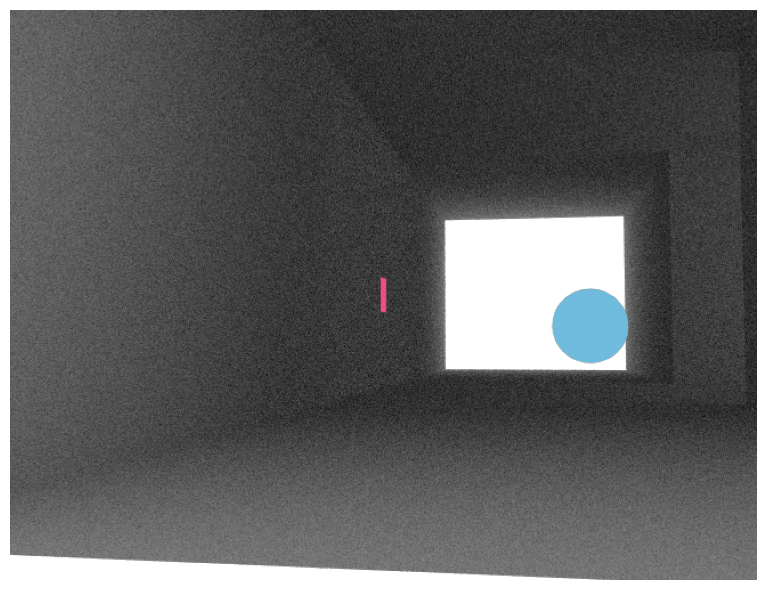

In [ ]:
scene.add(Camera("cam",
                         position=[20,0,1],
                         look_at=[2,-3,2]))
scene.render(camera="cam", num_samples=25);

# Custom RIS Transition Matrices with Differentiable Phase Logic
This section defines a custom class CustomSolverPaths that extends SolverPaths from Sionna RT, overriding the _ris_transition_matrices function to introduce a differentiable mechanism for RIS phase control. the approach interprets the imaginary part of the RIS scattering coefficients **to guide phase decisions**. A sharp sigmoid function is applied to the imaginary component to mimic a hard switch between phase states (e.g., 0° for real and 165° for complex reflections), enabling gradient-based phase control.

The result is a smooth and differentiable phase interpolation which allows optimization within a computation graph. After determining the phase angles, the method computes a complex phase rotation matrix (sigma_phi_matrix) scaled by an effective scattering coefficient (sigma_eff_value). This matrix is then applied to the RIS transition coefficients and masked using the RIS path visibility (ris_paths.mask). The final output is a polarization-preserving transition matrix compatible with the ray tracing engine, allowing the RIS to be optimized as part of an end-to-end differentiable wireless system.

In [5]:
from sionna.rt.solver_paths import SolverPaths # Import SolverPaths to modify the _ris_transition_matrices function
class CustomSolverPaths(SolverPaths):
    def _ris_transition_matrices(self, ris_paths, ris_paths_tmp):
        # Compute scattering coefficients
        sc = [tf.reduce_sum(r(), axis=0) for r in self._scene.ris.values()]
        sc = tf.concat(sc, axis=0)
        sc = sc[tf.newaxis, tf.newaxis, ...]


        # Coefficient calculation
        coef = tf.cast(4 * PI, self._rdtype)
        coef /= tf.reduce_prod(ris_paths_tmp.distances, axis=0)
        coef *= tf.cast(tf.sqrt(tx.power_dbm * 0.001 * 120 * PI * 2 * 66), self._rdtype)
        coef = tf.complex(coef, tf.cast(0, self._rdtype))

        # Differentiable phase decision: use magnitude of imag part
        imag_part = tf.math.imag(sc)

        # Sharpen sigmoid to approximate a step function: large scaling factor
        sharpness = 100000000.0  # Higher value = closer to hard decision
        phase_weight = tf.sigmoid(sharpness * imag_part)  # Step at imag_part = 0

        # Now interpolate between 0° for real (imag == 0) and 165° for complex (non-zero imag)
        phase_deg = phase_weight * 2 * 165.0


        # Convert to radians and cast
        phase_rad = phase_deg * (np.pi / 180.0)
        phase_rad = tf.cast(phase_rad, self._rdtype)


        # Compute complex phase rotation
        sigma_eff_value = 0.001  # Scalar value
        sqrt_sigma = tf.sqrt(tf.cast(sigma_eff_value, self._rdtype))
        sqrt_sigma = tf.complex(sqrt_sigma, tf.cast(0, self._rdtype))  # Ensure sqrt_sigma is complex
        sigma_phi_matrix = sqrt_sigma * tf.exp(
            tf.complex(0.0, phase_rad)  # Ensure exp result is complex
        )

        # Apply coefficient modification with masking
        coef *= sigma_phi_matrix
        coef = tf.where(ris_paths.mask, coef, tf.cast(0, coef.dtype))

        # Create polarization-preserving transition matrices
        coef = coef[..., tf.newaxis, tf.newaxis]
        ris_mat_t = coef * tf.eye(2, batch_shape=[1, 1, 1], dtype=self._dtype)

        return ris_mat_t

In [6]:
scene._solver_paths = CustomSolverPaths(scene) # Replace to custom SolverPaths

# Trainable RIS Phase Optimization using Straight-Through Estimator (STE)
This section implements a differentiable optimization technique for the RIS phase profile using a straight-through estimator (STE). Unlike the discrete ON/OFF search method, the RIS phases are modeled as trainable continuous variables (phase_var). A custom gradient function (binarize_phase) is applied, which maps continuous values to binary phase shifts (0 or π) during the forward pass, while allowing non-zero gradients only within a specified range during backpropagation to enable learning.

The training loop optimizes the RIS phase configuration over multiple iterations using the Adam optimizer. In each step, the RIS is updated with binarized phases, the channel impulse response (CIR) is computed via ray tracing (scene.compute_paths()), and the loss is defined as the negative average path gain in dB. This approach allows gradient-based optimization even in the presence of binary control, enhancing signal strength in a differentiable manner.

In [71]:
# Create trainable variables for phase (continuous)
phase_var = tf.Variable(tf.zeros_like(ris.phase_profile.values), trainable=True)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(0.01)
# Custumaze gradient so it still work in computation graph
@tf.custom_gradient
def binarize_phase(x):
    pi = tf.constant(np.pi, dtype=tf.float32)
    binary = tf.where(x > 0, pi, 0.0)         # Anything > 0 --> pi else 0
    def grad(dy):
        return dy * tf.cast(tf.logical_and(x > -1.5, x < 1.5), tf.float32) # Accept gradient between -1.5 and 1.5 ,other set to zero (no update)
    return binary, grad

def to_db(x):
    return 10*tf.math.log(x)/tf.math.log(10.)
# Training step
def train_step():
    with tf.GradientTape() as tape:
        # Apply binarized phase
        bin_phase = binarize_phase(phase_var)

        ris.phase_profile.values = bin_phase
        # Compute CIR and loss
        paths = scene.compute_paths()

        a = tf.squeeze(paths.cir()[0])
        a = tf.expand_dims(a, axis=-1)  # [2, 1] to match a_it

        path_gain = to_db(tf.reduce_mean(tf.reduce_sum(tf.abs(a)**2, axis=-1)))
        loss = -path_gain

    # Compute and apply gradients
    grads = tape.gradient(loss, [phase_var])
    optimizer.apply_gradients(zip(grads, [phase_var]))
    return path_gain, a

# Training loop
num_iterations = 30
for i in range(num_iterations):
    path_gain, a = train_step()

    if i % 10 == 0:
        print(f"Iteration {i}: Path Gain = {path_gain.numpy():.2f} dB")

Iteration 0: Path Gain = -60.32 dB
Iteration 10: Path Gain = -36.11 dB
Iteration 20: Path Gain = -36.36 dB


# RIS Phase Profile Optimization (Iterative ON/OFF Method)
This code performs a simple iterative optimization of the phase configuration for a Reconfigurable Intelligent Surface (RIS) using an ON/OFF strategy. Each element of the RIS is tested with two possible phase values (0 and π), and the configuration that maximizes the received path gain is selected. The optimization is done one element at a time, keeping previously optimized phases fixed.

The gain is evaluated by computing the path response using scene.compute_paths() and measuring the average received power in dB. This approach ensures that the RIS phase profile is adjusted to enhance signal strength at the receiver.

In [ ]:
# ON / OFF phases
_phases = [0.0, np.pi]

# We need [1, 16, 16] -> [256] total elements phases
original_shape = ris.phase_profile.values.shape
flat_phases = tf.reshape(ris.phase_profile.values, [-1])
num_elements = flat_phases.shape[0]

# Start with all-zero phase
best_phases = tf.zeros_like(flat_phases)

def compute_path_gain(): # Fn to compute gain
    paths = scene.compute_paths()
    a = tf.squeeze(paths.cir()[0])
    a = tf.expand_dims(a, axis=-1)
    return 10 * tf.math.log(tf.reduce_mean(tf.reduce_sum(tf.abs(a)**2, axis=-1))) / tf.math.log(10.0)

# Iteratively optimize each RIS element
for idx in range(num_elements):
    best_gain = -np.inf
    best_phase = 0.0

    for phase in _phases:
        updated = tf.tensor_scatter_nd_update(best_phases, [[idx]], [phase])
        reshaped = tf.reshape(updated, original_shape)
        ris.phase_profile.values = reshaped
        gain = compute_path_gain()

        if gain > best_gain:
            best_gain = gain
            best_phase = phase
            print(best_gain)


    # Set best phase in flat tensor
    best_phases = tf.tensor_scatter_nd_update(best_phases, [[idx]], [best_phase])
    print(best_phase)
# Final config
ris.phase_profile.values = tf.reshape(best_phases, original_shape)
final_gain = compute_path_gain()
print(f"Final Path Gain: {final_gain.numpy():.2f} dB")


**Final Path Gain: -37.58 dB**

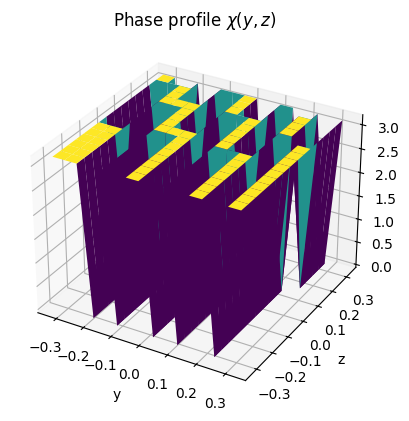

In [90]:
ris.phase_profile.show(0);

# Simulation Parameters

In [7]:
# SNR range for evaluation and training
ebno_db_min = -5.0
ebno_db_max = 10.0

## OFDM configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers
num_ofdm_symbols = 14 # Number of OFDM symbols
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain.

## Modulation and coding configuration
num_bits_per_symbol = 2 # QPSK
coderate = 0.5 # Coderate for LDPC code

## Neural receiver configuration
num_conv_channels = 12 # Number of convolutional channels for the convolutional layers forming the neural receiver

## Training configuration
training_batch_size = 128 # Training batch size
model_weights_path = "neural_receiver_weights" # Location to save the neural receiver weights once training is done

# Stream and Resource Grid Configuration
This code initializes the transmission structure by defining how data streams are managed and how they are placed within the OFDM resource grid. The StreamManagement object specifies the association between transmitters and receivers and configures one data stream per transmitter using a simple receiver-transmitter mapping.

The ResourceGrid defines the physical layer transmission layout, including the number of OFDM symbols, FFT size, subcarrier spacing, and cyclic prefix length. It also configures structural aspects like pilot symbol placement, null subcarriers, and guard bands. Together, these settings shape how data is encoded and transmitted over the system.

In [8]:
stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter
resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

# Codeword Length
This part computes the length of each codeword used in the communication system based on the structure of the OFDM resource grid. The total number of coded bits (n) is determined by multiplying the number of data-carrying resource elements in the grid by the number of bits transmitted per symbol, as defined by the modulation scheme.

The number of information bits (k) is then computed by applying the coding rate to n. This reflects how many actual data bits are embedded in each codeword before redundancy is added through channel coding, enabling reliable transmission in noisy environments.

In [9]:
# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate)

# Neural Receiver
The code defines a Keras-based neural receiver that utilizes residual convolutional layers to efficiently process the 2D resource grid formed from complex baseband signals. Noise power information is integrated into the input, allowing the receiver to adapt to varying channel conditions. Convolutional layers extract spatial features, while residual (skip) connections help mitigate vanishing gradients and support deeper architectures.

To facilitate this, a separate Keras layer is first defined to implement a residual block consisting of two convolutional layers and layer normalization. The full neural receiver is then built by stacking multiple such blocks, enabling robust and scalable feature extraction. The following figure illustrates the architecture of the neural receiver.

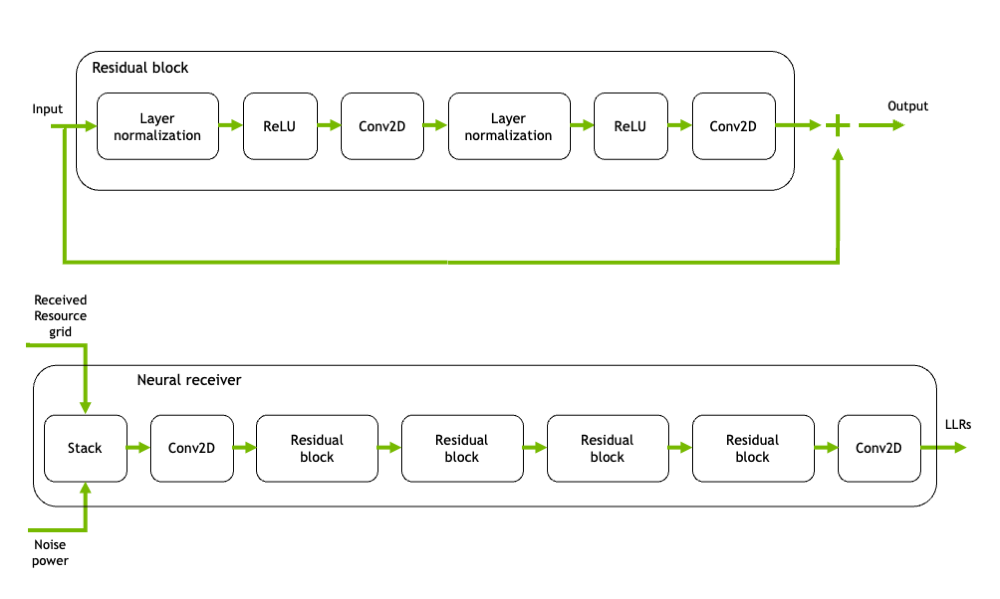

In [10]:
class ResidualBlock(Layer):

    def build(self, input_shape):

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[2,2],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[2,2],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z)
        z = z + inputs

        return z

class NeuralReceiver(Layer):

    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[2,2],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[2,2],
                                   padding='same',
                                   activation=None)

    def call(self, inputs):
        y, no = inputs

        # Feeding the noise power in log10 scale
        no = log10(no)
        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        return z

# Channel Frequency Response Computation
This section computes the channel's frequency response based on the multipath propagation characteristics of a simulated environment. Using the scene.compute_paths() method, it traces signal paths up to a defined depth, capturing reflections and scatterings. The resulting complex amplitudes a and delays tau are used to represent the channel's impulse response.

To evaluate how the channel affects OFDM subcarriers, the code calculates the subcarrier frequencies and centers them around the carrier. It then converts the time-domain channel impulse response into a frequency-domain representation using cir_to_ofdm_channel(). This yields the channel’s frequency response h_freq.

In [72]:
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)

a, tau = paths.cir()
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True)

# End-to-End Communication System
This class defines an end-to-end (E2E) communication system using Keras, integrating both traditional and neural components. It models the full transmission chain: binary source, optional LDPC encoding, QAM modulation, resource grid mapping, OFDM channel application, and a neural receiver. In inference mode, LDPC decoding is also applied to recover the original bits. The system supports training and evaluation modes, enabling flexible use across learning and benchmarking tasks.

When training, the system computes the bit-metric decoding (BMD) rate, a surrogate for mutual information in bit-interleaved coded modulation (BICM) systems, and uses it as the optimization target. In inference mode, the input bits are encoded, passed through the OFDM channel, demodulated using a neural receiver, and finally decoded to obtain predictions.

In [61]:
class E2ESystem(Model):


    def __init__(self, system, training=False):
        super().__init__()
        self._system = system
        self._training = training

        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)
        ######################################
        ## Channel
        self._channel = ApplyOFDMChannel(add_awgn=True)
        ######################################
        ## Receiver
        if system == "neural-receiver": # Neural receiver
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    @tf.function
    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        no_ = expand_to_rank(no, tf.rank(x_rg))
        # channel
        y   = self._channel([x_rg,h_freq, no_])
        if self._system == "neural-receiver":
            # The neural receiver computes LLRs from the frequency domain received symbols and N0
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver([y, no])
            llr = insert_dims(llr, 2, 1) # Reshape the input to fit what the resource grid demapper is expected
            llr = self._rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
            llr = tf.reshape(llr, [batch_size, 1, 1, n]) # Reshape the LLRs to fit what the outer decoder is expected
        if self._training:
            # Compute and return BMD rate (in bit), which is known to be an achievable
            # information rate for BICM systems.
            # Training aims at maximizing the BMD rate
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            return rate
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat # for BER/BLER computation

In [13]:
num_training_iterations = 300 # Number of training iterations

# Training the End-to-End System
This section initializes and trains the end-to-end communication system using a neural receiver in training mode. The model is optimized to maximize the bit-metric decoding (BMD) rate, which reflects the amount of reliably transmittable information in bit-interleaved coded modulation (BICM) systems. An Adam optimizer is used, and at each training step, a random SNR (Eb/N₀) is sampled within a specified range to promote robustness across varying channel conditions.

During each iteration, the model performs a forward pass to compute the BMD rate, and the negative of this rate is treated as the loss to be minimized. Using TensorFlow’s automatic differentiation (GradientTape), gradients of the loss are computed with respect to the trainable weights, and the optimizer updates the model accordingly. Training progress is periodically printed, showing how the system improves its achievable information rate over time.

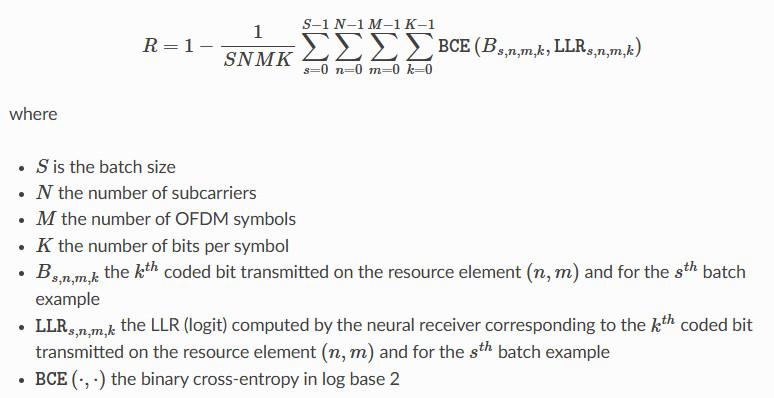

In [79]:
training = True
if training:
    model = E2ESystem('neural-receiver', training=True)

    optimizer = tf.keras.optimizers.Adam(0.001)

    for i in range(num_training_iterations):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            rate = model(training_batch_size, ebno_db)
            loss = -rate

        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        if i % 100 == 0:
            print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')



0.80055356
0.63908637
0.5027859
0.38613558
0.3263358
0.27341676
0.26533055
0.26855314
0.3441031
0.2559831
0.24911845
0.26421678
0.2017231
0.16914892
0.15140295
0.13241601
0.11600089
0.24807084
0.10029507
0.17715669
0.08731854
0.14461279
0.18331587
0.062758684
0.05970776
0.12258935
0.039667606
0.05702889
0.11643803
0.007532716
0.116191864
0.020443678
0.01652944
0.0177387
0.06553352
-0.027276695
-0.009372234
-0.004535556
-0.0020290613
-0.036497056
-0.051080763
0.0654906
0.0008727312
-0.0709371
-0.041539133
-0.0876255
0.012068152
-0.07632351
-0.100515425
-0.094182014
-0.09434736
-0.008105218
-0.11561173
-0.015447855
-0.075134516
-0.13499677
-0.1298998
-0.103668034
-0.096272886
-0.1485973
-0.10321188
-0.13732558
-0.13095587
-0.07210165
-0.10085201
-0.13701546
-0.09192276
-0.04647529
-0.08062631
-0.18774521
-0.20467097
-0.18583965
-0.14619869
-0.21821988
-0.20948768
-0.20307314
-0.23197365
-0.19116205
-0.19809628
-0.17737997
-0.16684985
-0.23815167
-0.16813016
-0.2741815
-0.25389582
-0.1883

**Final Loss: -0.90**

# Saving Model Weights
This function provides a simple method to save the trained weights of a model for later use. By calling model.get_weights(), it extracts the current values of all trainable and non-trainable parameters from the model.

These weights are then serialized and saved to a file using Python’s pickle module. Storing weights in this manner allows the model to be reloaded later without retraining.

In [80]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

In [81]:
save_weights(model, model_weights_path)

In [82]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     1) # Step

# Loading Model Weights
This function restores previously saved weights into a model, enabling reuse without retraining. Before loading, the model is called once with dummy inputs to initialize its internal variables and structure—this is necessary to prepare it to receive the weights.

The weights are then deserialized using Python’s pickle module and applied to the model using set_weights(). This approach ensures that the model resumes with the exact parameters it had during saving, allowing consistent inference or continued training from a saved state.

In [83]:
# function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

# Evaluating the Trained Model
This section loads a trained end-to-end communication model in evaluation mode to assess its performance. A new instance of the model is created with training=False to disable training-specific behavior (e.g., loss computation), and its weights are restored using the previously saved file.

The model is then evaluated using the sim_ber() function, which simulates transmission over a range of SNR values (ebno_dbs) to compute the block error rate (BLER). The simulation runs until a target number of block errors or a maximum number of Monte Carlo iterations is reached, providing a quantitative measure of the system's reliability under realistic conditions.

In [84]:
model_conventional = E2ESystem('neural-receiver', training=False)
load_weights(model_conventional, model_weights_path)
_,bler = sim_ber(model_conventional, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)


# The following cells performs one forward step through the end-to-end system

In [73]:
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)
neural_receiver = model_conventional._neural_receiver
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)
channel = ApplyOFDMChannel(add_awgn=True)

# Step-by-Step Forward Pass through the System
This script performs a manual forward pass through the end-to-end communication pipeline for a batch size of one at a fixed SNR (Eb/N₀ = 5 dB). It begins by generating binary codewords from the source, mapping them to QAM symbols, and then placing those symbols into a 2D OFDM resource grid. The code also computes the corresponding noise variance for the given SNR and prepares the frequency response of the channel for simulation.

The OFDM channel (including AWGN) is applied to the resource grid, yielding received symbols. These are then processed by a neural receiver to compute log-likelihood ratios (LLRs). The LLRs are reshaped and passed through a resource grid demapper to extract only the useful data-carrying elements. Throughout the process, tensor shapes are printed for debugging and to verify proper data flow through each stage of the system.

In [86]:
batch_size = 1
ebno_db = tf.fill([batch_size], 5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
## Transmitter
# Generate codewords
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)
# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)
# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)
print("h_freq shape: ", h_freq.shape)
######################################
## Channel
no_ = expand_to_rank(no, tf.rank(x_rg))
print("no shape: ", no.shape)
print("no_ shape: ", no_.shape)
# Apply channel
channel = ApplyOFDMChannel(add_awgn=True)
y = channel([x_rg, h_freq, no])
print("y shape: ", y.shape)
######################################
## Receiver
y = tf.squeeze(y, axis=1)
print("y squeze: ", y.shape)
llr = neural_receiver([y, no])
print("llr shape: ", llr.shape)
# Reshape the input to fit what the resource grid demapper is expected
llr = insert_dims(llr, 2, 1)
print("llr insert: ", llr.shape)
# Extract data-carrying resource elements. The other LLRs are discarded
llr = rg_demapper(llr)
print("llr after dem: ", llr.shape)
llr = tf.reshape(llr, [batch_size, 1, 1, n])
print("Post RG-demapper LLRs: ", llr.shape)

c shape:  (1, 1, 1, 2784)
x shape:  (1, 1, 1, 1392)
x_rg shape:  (1, 1, 1, 14, 128)
h_freq shape:  (1, 1, 2, 1, 1, 1, 128)
no shape:  (1,)
no_ shape:  (1, 1, 1, 1, 1)
y shape:  (1, 1, 2, 14, 128)
y squeze:  (1, 2, 14, 128)
llr shape:  (1, 14, 128, 2)
llr insert:  (1, 1, 1, 14, 128, 2)
llr after dem:  (1, 1, 1, 1392, 2)
Post RG-demapper LLRs:  (1, 1, 1, 2784)


# Rate in 1st RIS training cycle

In [24]:
bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
bce = tf.reduce_mean(bce)
rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
print(f"Rate: {rate:.2E} bit")

Rate: 9.01E-01 bit


# Rate in 2nd RIS training cycle

In [87]:
bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
bce = tf.reduce_mean(bce)
rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
print(f"Rate: {rate:.2E} bit")

Rate: 9.18E-01 bit
